In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.image import imread

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# # Set TPU strategy
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [3]:
path = "/kaggle/input/plant-disease-classification-merged-dataset"
os.listdir(path)

['Tomato__septoria_leaf_spot',
 'Tea__anthracnose',
 'Rice__hispa',
 'Soybean__diabrotica_speciosa',
 'Tomato__healthy',
 'Gauva__diseased',
 'Wheat__yellow_rust',
 'Soybean__downy_mildew',
 'Pomegranate__diseased',
 'Apple__rust',
 'Tea__algal_leaf',
 'Pomegranate__healthy',
 'Tomato__early_blight',
 'Peach__bacterial_spot',
 'Soybean__healthy',
 'Potato__healthy',
 'Cherry__healthy',
 'Apple__healthy',
 'Rice__neck_blast',
 'Wheat__septoria',
 'Jamun__healthy',
 'Strawberry___leaf_scorch',
 'Coffee__rust',
 'Mango__healthy',
 'Mango__diseased',
 'Apple__black_rot',
 'Soybean__powdery_mildew',
 'Lemon__healthy',
 'Pepper_bell__healthy',
 'Strawberry__healthy',
 'Cassava__healthy',
 'Corn__healthy',
 'Jamun__diseased',
 'Corn__common_rust',
 'Tomato__yellow_leaf_curl_virus',
 'Coffee__cercospora_leaf_spot',
 'Grape__black_measles',
 'Rice__healthy',
 'Tea__healthy',
 'Soybean__caterpillar',
 'Grape__leaf_blight_(isariopsis_leaf_spot)',
 'Coffee__red_spider_mite',
 'Soybean__rust',
 'To

In [4]:
# Create an instance of ImageDataGenerator for normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an instance of ImageDataGenerator for normalization for testing
test_datagen = ImageDataGenerator(rescale=1./255)

input_size = (224,224)

# Set the batch size
batch_size = 64

In [5]:
# List all subdirectories in the given path
subdirectories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Create lists to store filenames and labels
filenames = []
labels = []

# Iterate through each subdirectory
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(path, subdirectory)

    # List all files in the subdirectory
    image_files = [f for f in os.listdir(subdirectory_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Append filenames and labels to the lists
    filenames.extend([os.path.join(subdirectory, file) for file in image_files])
    labels.extend([subdirectory] * len(image_files))

# Convert lists to numpy arrays
filenames = np.array(filenames)
labels = np.array(labels)

In [6]:
len(np.unique(labels))

88

In [7]:
# Calculate statistics
total_samples = len(labels)
unique_labels, class_counts = np.unique(labels, return_counts=True)
average_samples_per_class = total_samples / len(unique_labels)
min_samples_in_class = min(class_counts)
max_samples_in_class = max(class_counts)

# Print statistics
print("Total Samples:", total_samples)
print("Average Samples per Class:", average_samples_per_class)
print("Min Samples in a Class:", min_samples_in_class)
print("Max Samples in a Class:", max_samples_in_class)

Total Samples: 79086
Average Samples per Class: 898.7045454545455
Min Samples in a Class: 22
Max Samples in a Class: 11390


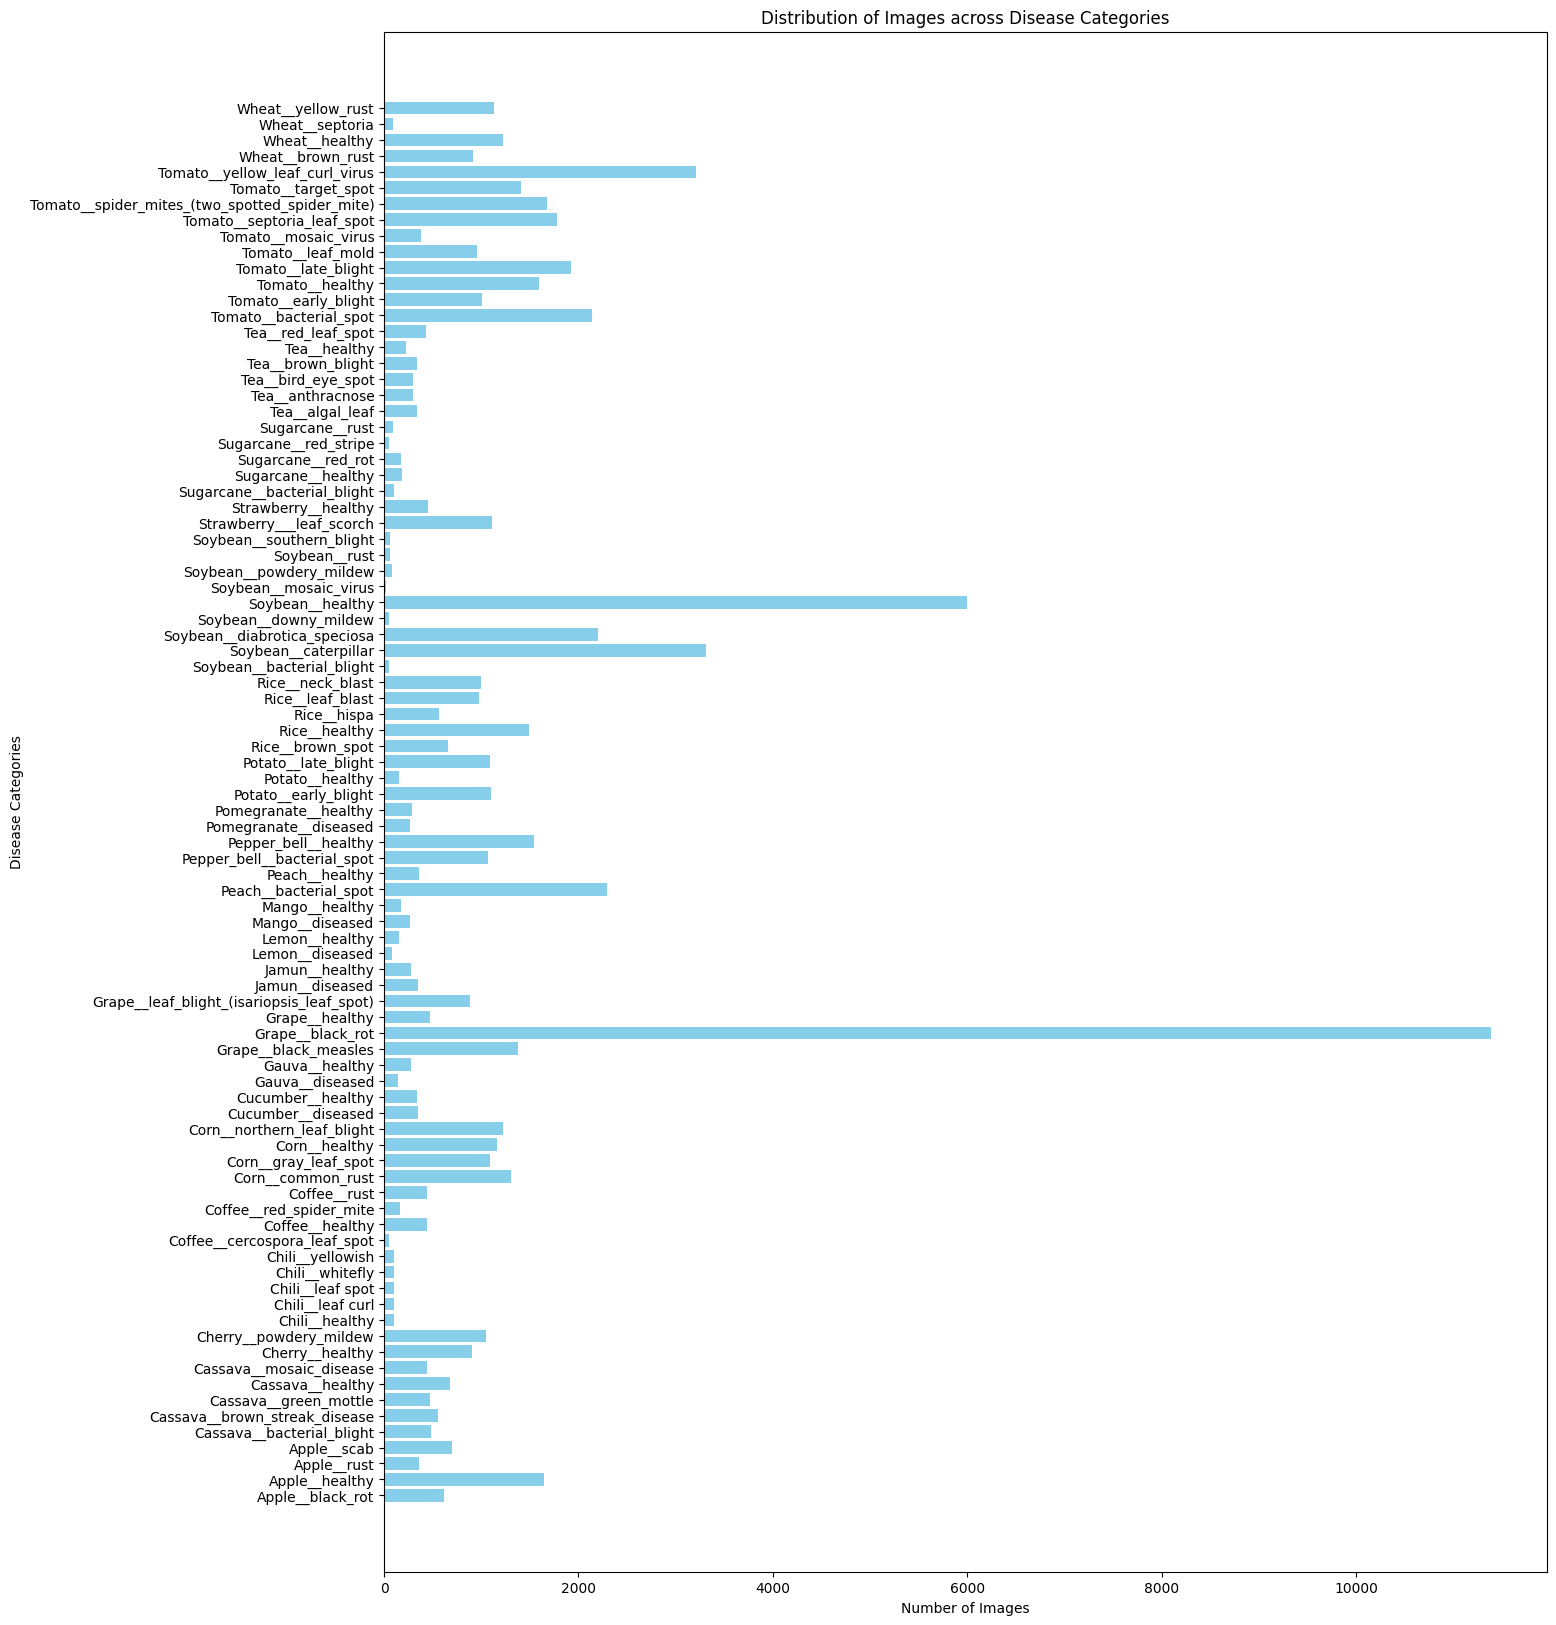

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Count the occurrences of each label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Set the size of the plot
plt.figure(figsize=(15, 20))  # Adjust the figure size accordingly

# Plot the horizontal bar chart
plt.barh(unique_labels, label_counts, color='skyblue')  # You can customize the color if needed
plt.xlabel('Number of Images')
plt.ylabel('Disease Categories')
plt.title('Distribution of Images across Disease Categories')

# Show the plot
plt.show()


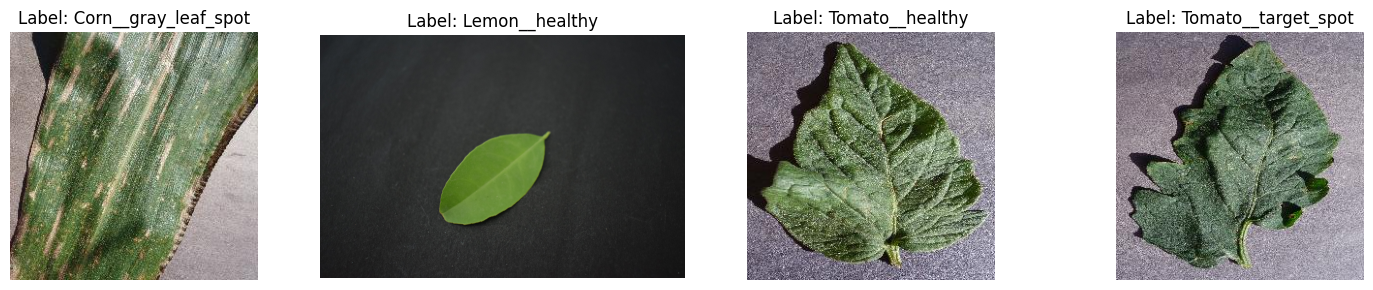

In [9]:
# Display a few images along with their labels in the same row
num_images_to_display = 4  # Change this to the desired number of images
selected_indices = np.random.choice(len(filenames), num_images_to_display, replace=False)

# Set up the subplots
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i, index in enumerate(selected_indices):
    image_path = os.path.join(path, filenames[index])
    label = labels[index]

    # Load and display the image using PIL
    img = Image.open(image_path)
    
    # You can optionally resize the image if needed
    # img = img.resize((width, height))

    # Display the image on the corresponding subplot
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()

In [10]:
import numpy as np

# Assuming labels is a NumPy array
unique_labels = np.unique(labels)

# Print all unique labels
print(unique_labels)

['Apple__black_rot' 'Apple__healthy' 'Apple__rust' 'Apple__scab'
 'Cassava__bacterial_blight' 'Cassava__brown_streak_disease'
 'Cassava__green_mottle' 'Cassava__healthy' 'Cassava__mosaic_disease'
 'Cherry__healthy' 'Cherry__powdery_mildew' 'Chili__healthy'
 'Chili__leaf curl' 'Chili__leaf spot' 'Chili__whitefly'
 'Chili__yellowish' 'Coffee__cercospora_leaf_spot' 'Coffee__healthy'
 'Coffee__red_spider_mite' 'Coffee__rust' 'Corn__common_rust'
 'Corn__gray_leaf_spot' 'Corn__healthy' 'Corn__northern_leaf_blight'
 'Cucumber__diseased' 'Cucumber__healthy' 'Gauva__diseased'
 'Gauva__healthy' 'Grape__black_measles' 'Grape__black_rot'
 'Grape__healthy' 'Grape__leaf_blight_(isariopsis_leaf_spot)'
 'Jamun__diseased' 'Jamun__healthy' 'Lemon__diseased' 'Lemon__healthy'
 'Mango__diseased' 'Mango__healthy' 'Peach__bacterial_spot'
 'Peach__healthy' 'Pepper_bell__bacterial_spot' 'Pepper_bell__healthy'
 'Pomegranate__diseased' 'Pomegranate__healthy' 'Potato__early_blight'
 'Potato__healthy' 'Potato__lat

In [11]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
numerical_labels = label_encoder.fit_transform(labels)

In [12]:
np.unique(numerical_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [24]:
# Reverse transform numerical labels to original class names
inverse = label_encoder.inverse_transform(numerical_labels)

unique_labels = np.unique(inverse)

# Print all unique labels
print(unique_labels)

['Apple__black_rot' 'Apple__healthy' 'Apple__rust' 'Apple__scab'
 'Cassava__bacterial_blight' 'Cassava__brown_streak_disease'
 'Cassava__green_mottle' 'Cassava__healthy' 'Cassava__mosaic_disease'
 'Cherry__healthy' 'Cherry__powdery_mildew' 'Chili__healthy'
 'Chili__leaf curl' 'Chili__leaf spot' 'Chili__whitefly'
 'Chili__yellowish' 'Coffee__cercospora_leaf_spot' 'Coffee__healthy'
 'Coffee__red_spider_mite' 'Coffee__rust' 'Corn__common_rust'
 'Corn__gray_leaf_spot' 'Corn__healthy' 'Corn__northern_leaf_blight'
 'Cucumber__diseased' 'Cucumber__healthy' 'Gauva__diseased'
 'Gauva__healthy' 'Grape__black_measles' 'Grape__black_rot'
 'Grape__healthy' 'Grape__leaf_blight_(isariopsis_leaf_spot)'
 'Jamun__diseased' 'Jamun__healthy' 'Lemon__diseased' 'Lemon__healthy'
 'Mango__diseased' 'Mango__healthy' 'Peach__bacterial_spot'
 'Peach__healthy' 'Pepper_bell__bacterial_spot' 'Pepper_bell__healthy'
 'Pomegranate__diseased' 'Pomegranate__healthy' 'Potato__early_blight'
 'Potato__healthy' 'Potato__lat

In [13]:
# Split your data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(filenames, numerical_labels, test_size=0.1, random_state=42, stratify=numerical_labels)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert string labels to integers for all sets
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [14]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [15]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [16]:
# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': x_train, 'class': y_train}),
    directory=path,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for numerical labels
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': x_val, 'class': y_val}),
    directory=path,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for numerical labels
    shuffle=False  # No shuffling for validation
)

test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': x_test, 'class': y_test}),
    directory=path,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='raw',  # Use 'raw' for numerical labels
    shuffle=False  # No shuffling for testing
)

Found 71177 validated image filenames.
Found 3954 validated image filenames.
Found 3955 validated image filenames.


## DenseNet Model 

In [17]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import pandas as pd
import numpy as np

# Build DenseNet model
densenet = DenseNet121(weights='imagenet', include_top=False)

input = Input(shape=(224, 224, 3))
x = Conv2D(3, (3, 3), padding='same')(input)

x = densenet(x)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Add another Dense layer
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Multi output
output = Dense(88, activation='softmax', name='root')(x)

# Model
model = Model(input, output)

# Using ExponentialDecay for learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)
model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024   7037504   
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                               

In [18]:
# from sklearn.utils.class_weight import compute_class_weight
# from tabulate import tabulate

# # Get unique class labels from your DataFrame
# unique_classes = np.unique(y_train)

# # Calculate class weights using unique class labels
# class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)

# # Convert to dictionary
# class_weight_dict = dict(zip(unique_classes, class_weights))

# # Print class weights in a table
# table = tabulate(class_weight_dict.items(), headers=['Class', 'Weight'], tablefmt='pretty')
# print(table)

In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [20]:
# Build and train the model
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', verbose=1, save_best_only=True)

# Fits the model on batches with real-time data augmentatio
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    callbacks=[annealer, checkpoint],
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
#     class_weight=class_weight_dict  # Pass the class weights here
)

Epoch 1/30
  53/1113 [>.............................] - ETA: 22:46 - loss: 4.3245 - accuracy: 0.1436

KeyboardInterrupt: 

## Plotting the history

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Visualizing the predictions

In [26]:
predicted_labels_test

array([78, 75, 21, ..., 83, 85, 76])

In [28]:
predicted_class_names_test

array(['Tomato__leaf_mold', 'Tomato__early_blight',
       'Corn__gray_leaf_spot', ..., 'Tomato__yellow_leaf_curl_virus',
       'Wheat__healthy', 'Tomato__healthy'], dtype='<U46')

62/62 [==============================] - 46s 720ms/step


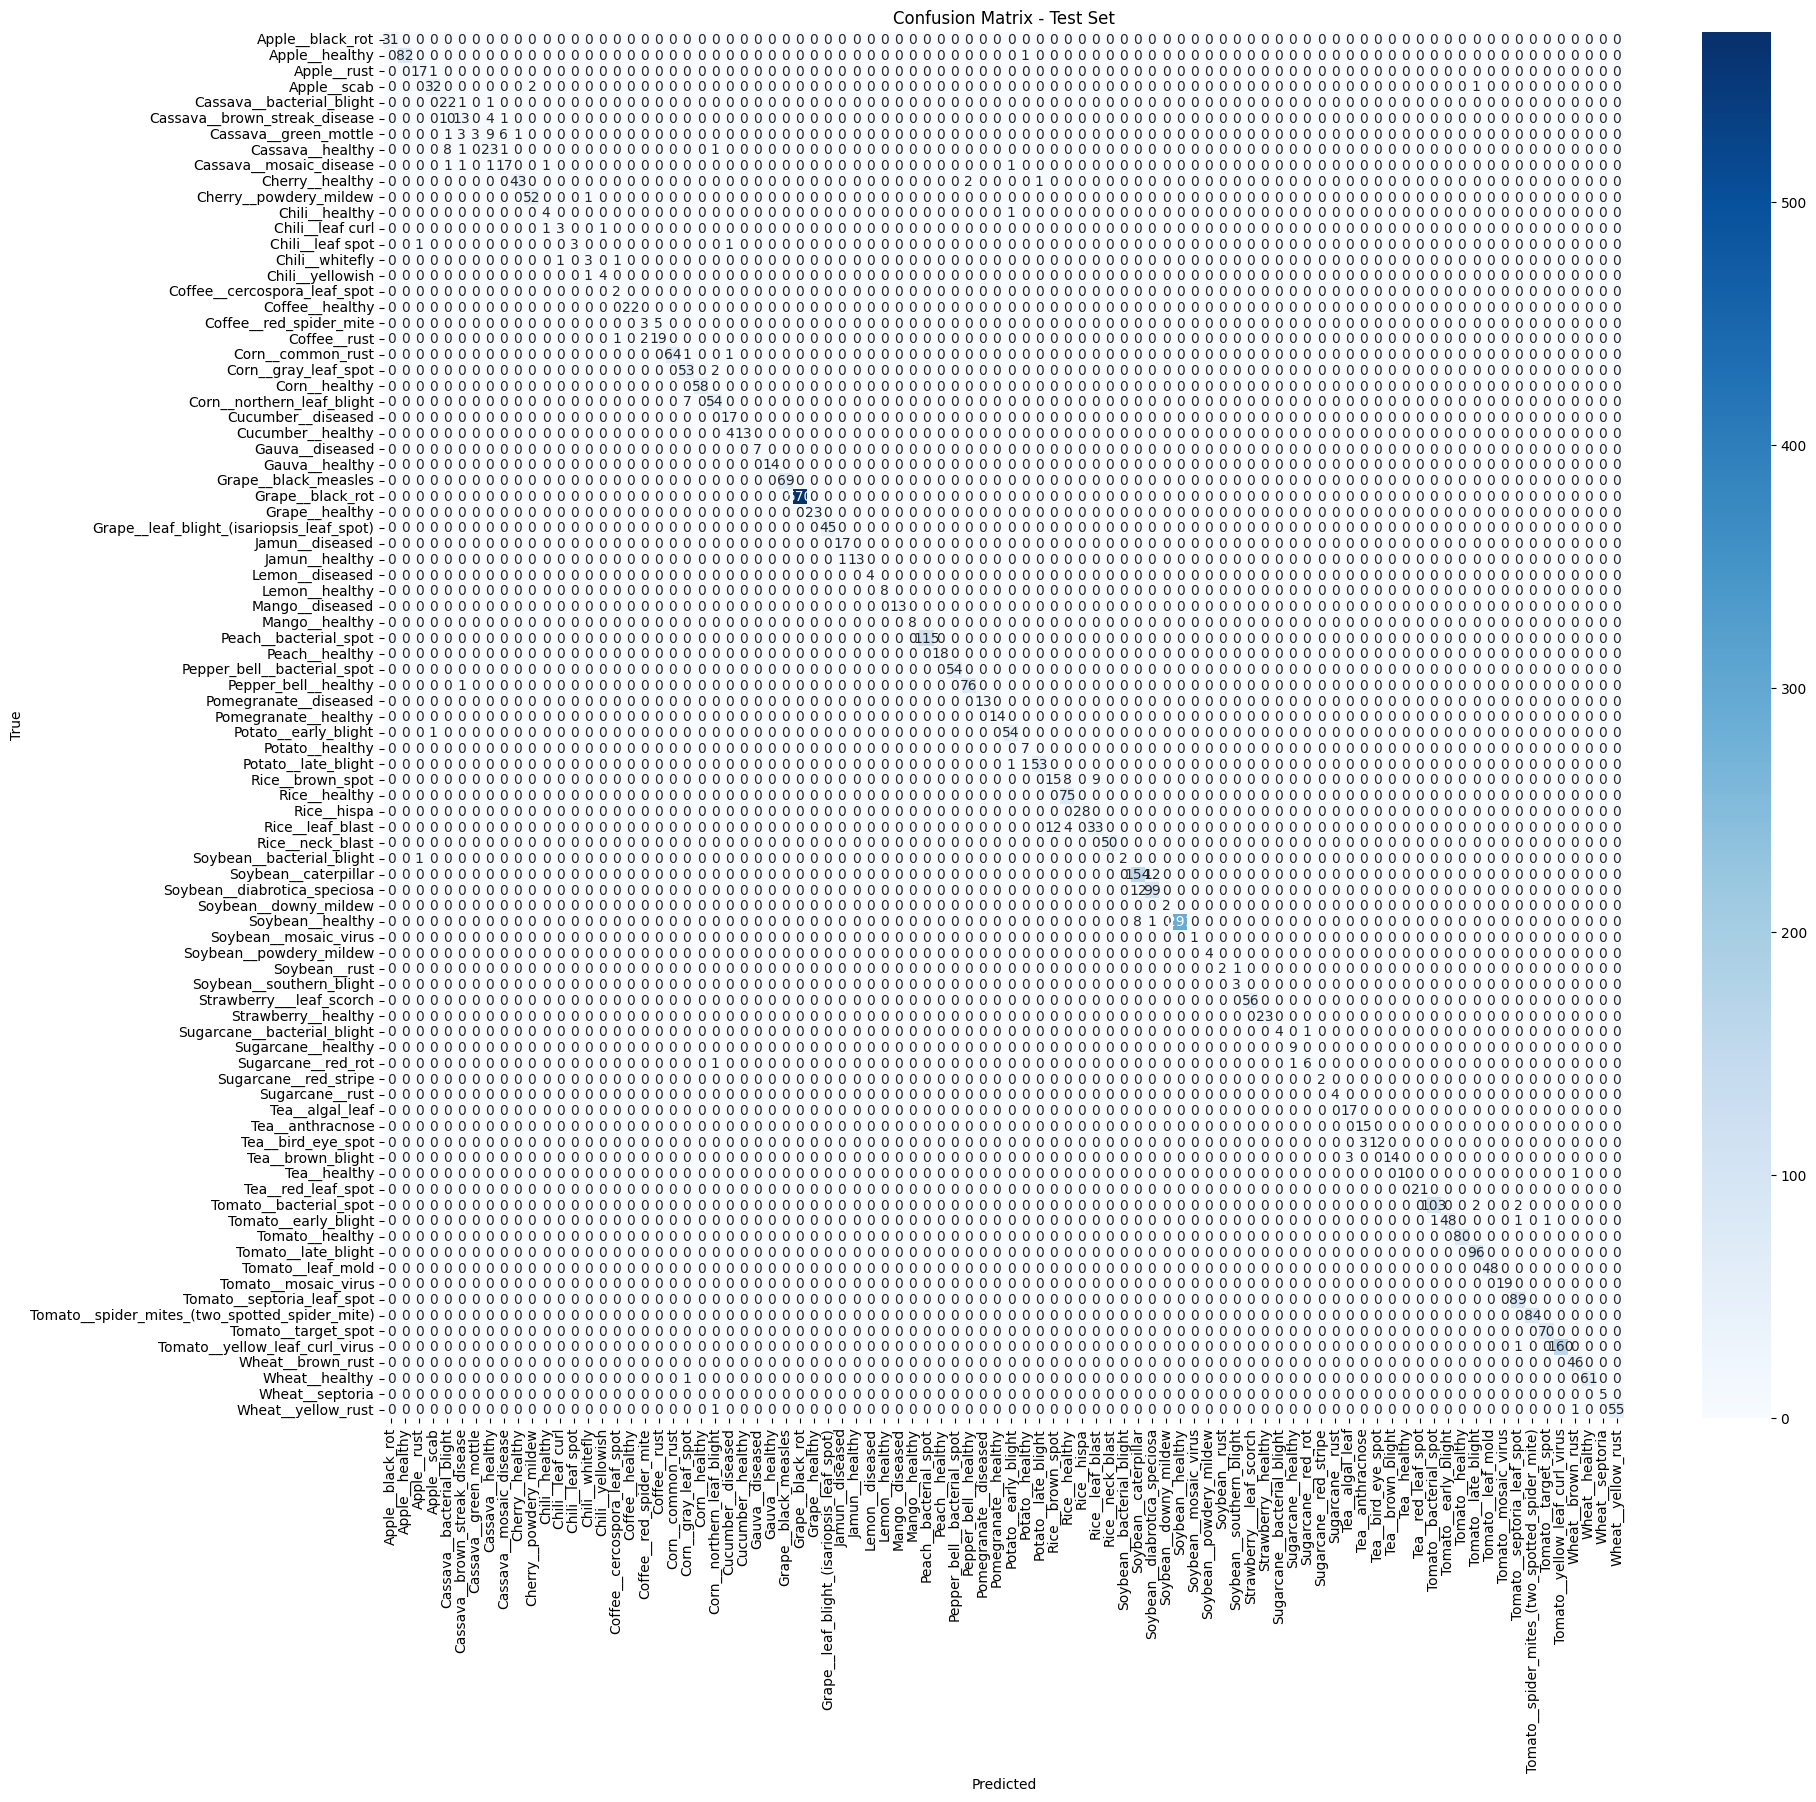

Classification Report - Test Set:
                                                precision    recall  f1-score   support

                              Apple__black_rot       1.00      1.00      1.00        31
                                Apple__healthy       1.00      0.99      0.99        83
                                   Apple__rust       0.89      0.94      0.92        18
                                   Apple__scab       0.94      0.91      0.93        35
                     Cassava__bacterial_blight       0.52      0.92      0.67        24
                 Cassava__brown_streak_disease       0.65      0.46      0.54        28
                         Cassava__green_mottle       1.00      0.13      0.23        23
                              Cassava__healthy       0.61      0.68      0.64        34
                       Cassava__mosaic_disease       0.68      0.77      0.72        22
                               Cherry__healthy       0.98      0.93      0.96        

In [23]:
# Load the saved model
model = load_model('/kaggle/input/densenet-model/model.h5')  # Replace 'path_to_your_model.h5' with the actual path

# Assuming you have a test generator named test_generator
# Generate predictions on the test set
predictions_test = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels_test = np.argmax(predictions_test, axis=1)

# Get true labels
true_labels_test = test_generator.labels

# Reverse transform numerical labels to original class names using label encoder
predicted_class_names_test = label_encoder.inverse_transform(predicted_labels_test)
true_class_names_test = label_encoder.inverse_transform(true_labels_test)

# Get unique class labels
unique_labels = label_encoder.classes_

# Compute confusion matrix for the test set
cm_test = confusion_matrix(true_class_names_test, predicted_class_names_test)

# Plot the heatmap with actual class labels
plt.figure(figsize=(20, 18))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("Classification Report - Test Set:")
report = classification_report(true_class_names_test, predicted_class_names_test, target_names=[str(i) for i in unique_labels])
print(report)
